In [1]:
scriptdirectory = "C:/Users/User/Documents/JO/gitkraken/MEA_analysis/Tübingen_Branch"
inputdirectory = r"D:\Files_Reutlingen_Jenny\19-04-16\190416_h5"


In [2]:
import os
os.chdir(scriptdirectory)

In [3]:
import sys
import numpy as np
import pandas as pd
import importlib

import McsPy
import McsPy.McsData
import McsPy.McsCMOS
from McsPy import ureg, Q_

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from scipy.signal import butter, lfilter, freqz, find_peaks, correlate, gaussian, filtfilt
from scipy import stats
from scipy import signal

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from Butterworth_Filter import butter_bandpass, butter_bandpass_filter

import glob
from plot_signal_and_spikes import plot_signal_and_spikes_from_bandpassfilteredsignal
import time

from neo.core import AnalogSignal
import quantities as pq

from elephant.spectral import welch_psd
from elephant.current_source_density import estimate_csd


%matplotlib notebook

In [4]:
timestr = time.strftime("%d%m%Y")
outputdirectory=r"D:\Files_Reutlingen_Jenny\19-04-16\190416_paper\poster_reutlingen"

### Import of all Custom Functions

In [16]:

def get_channel_infos(filedirectory, meafile):
    channel_raw_data = McsPy.McsData.RawData(os.path.join(filedirectory, 
                                                          meafile))
    print(channel_raw_data.recordings)
    print(channel_raw_data.comment)
    print(channel_raw_data.date)
    print(channel_raw_data.clr_date)
    print(channel_raw_data.date_in_clr_ticks)
    print(channel_raw_data.file_guid)
    print(channel_raw_data.mea_name)
    print(channel_raw_data.mea_sn)
    print(channel_raw_data.mea_layout)
    print(channel_raw_data.program_name)
    print(channel_raw_data.program_version)
    analognumber = len(channel_raw_data.recordings[0].analog_streams.keys())
    print('In total '+ str(analognumber) 
          + " analog_streams were identified.\n")
    for i in range(len(channel_raw_data.recordings[0].analog_streams.keys())):
        keylist = []
        stream = channel_raw_data.recordings[0].analog_streams[i]
        for key in stream.channel_infos.keys():
                keylist.append(key)
        channel_id = keylist[0]
        datapoints = channel_raw_data.recordings[0].analog_streams[i].channel_data.shape[1]
        samplingfrequency = stream.channel_infos[channel_id].sampling_frequency
        ticks = stream.channel_infos[channel_id].info['Tick']
        time = stream.get_channel_sample_timestamps(channel_id)
        scale_factor_for_second = Q_(1,time[1]).to(ureg.s).magnitude
        time_in_sec = time[0] * scale_factor_for_second
        timelengthrecording_ms = time[0][-1]+ticks
        timelengthrecording_s = (time[0][-1]+ticks)*scale_factor_for_second
        print("analog_stream Nr. " + str(i) + ": ")
        print("datapoints measured = " + str(datapoints))
        print("sampling frequency = " + str(samplingfrequency))
        print("ticks = " + str(ticks))
        print("total recordingtime is: " 
              + str(timelengthrecording_s) + "seconds \n")




def get_MEA_Signal(analog_stream, channel_idx, from_in_s=0, to_in_s=None):
    '''
    Extracts one Channels (channel_idx) Sginal 
    
    :param analog_stream = the analogstream from one recording
    :param channel_idx   = the channel index of the channel where you 
                            extract the values from
    :param from_in_s     = starting point of the range you want to observe 
                            in seconds
    :param to_in_s       = ending point of the range you want to observe. 
                            Default is None (i.e. whole range)
    
    Returns: the signal in uV, time stamps in sec, the sampling frequency
    
    
    '''
    ids = [c.channel_id for c in analog_stream.channel_infos.values()]
    channel_id = ids[channel_idx]
    channel_info = analog_stream.channel_infos[channel_id]
    sampling_frequency = channel_info.sampling_frequency.magnitude

    # get start and end index
    from_idx = max(0, int(from_in_s * sampling_frequency))
    if to_in_s is None:
        to_idx = analog_stream.channel_data.shape[1]
    else:
        to_idx = min(
            analog_stream.channel_data.shape[1], 
            int(to_in_s * sampling_frequency)
            )

    # get the timestamps for each sample
    time = analog_stream.get_channel_sample_timestamps(
        channel_id, from_idx, to_idx
        )

    # scale time to seconds:
    scale_factor_for_second = Q_(1,time[1]).to(ureg.s).magnitude
    time_in_sec = time[0] * scale_factor_for_second

    # get the signal
    signal = analog_stream.get_channel_in_range(channel_id, from_idx, to_idx)

    # scale signal to µV:
    scale_factor_for_uV = Q_(1,signal[1]).to(ureg.uV).magnitude
    signal_in_uV = signal[0] * scale_factor_for_uV
    
    return signal_in_uV, time_in_sec, sampling_frequency, scale_factor_for_second


def get_MEA_Channel_labels(np_analog_for_filter):
    '''
    Gives a List of all MEA Channel Labels (e.g. R12) in the order they appear
    within the recording.
    
    :param analogstream_data = an numpy array shape(channels, data)
    
    '''
    labellist = []
    for i in range(0, len(np_analog_for_filter)):
        #channel_idx = i
        ids = [c.channel_id for c in analog_stream_0.channel_infos.values()]
        channel_id = ids[i]
        channel_info = analog_stream_0.channel_infos[channel_id]
        #print(channel_info.info['Label'])
        labellist.append(channel_info.info['Label'])
    return labellist
    

def detect_threshold_crossings(signal, fs, threshold, dead_time):
    """
    Detect threshold crossings in a signal with dead time and return 
    them as an array

    The signal transitions from a sample above the threshold to a sample 
    below the threshold for a detection and
    the last detection has to be more than dead_time apart 
    from the current one.

    :param signal: The signal as a 1-dimensional numpy array
    :param fs: The sampling frequency in Hz
    :param threshold: The threshold for the signal
    :param dead_time: The dead time in seconds.
    """
    dead_time_idx = dead_time * fs
    threshold_crossings = np.diff(
        (signal <= threshold).astype(int) > 0).nonzero()[0]
    distance_sufficient = np.insert(
        np.diff(threshold_crossings) >= dead_time_idx, 0, True
        )
    while not np.all(distance_sufficient):
        # repeatedly remove all threshold crossings that violate the dead_time
        threshold_crossings = threshold_crossings[distance_sufficient]
        distance_sufficient = np.insert(
            np.diff(threshold_crossings) >= dead_time_idx, 0, True
            )
    return threshold_crossings


def get_next_minimum(signal, index, max_samples_to_search):
    """
    Returns the index of the next minimum in the signal after an index

    :param signal: The signal as a 1-dimensional numpy array
    :param index: The scalar index
    :param max_samples_to_search: The number of samples to search for a 
                                    minimum after the index
    """
    search_end_idx = min(index + max_samples_to_search, signal.shape[0])
    min_idx = np.argmin(signal[index:search_end_idx])
    return index + min_idx


def align_to_minimum(signal, fs, threshold_crossings, search_range, first_time_stamp=0):
    """
    Returns the index of the next negative spike peak for all threshold crossings

    :param signal: The signal as a 1-dimensional numpy array
    :param fs: The sampling frequency in Hz
    :param threshold_crossings: The array of indices where the signal 
                                crossed the detection threshold
    :param search_range: The maximum duration in seconds to search for the 
                         minimum after each crossing
    """
    search_end = int(search_range*fs)
    aligned_spikes = [get_next_minimum(signal, t, search_end) for t in threshold_crossings]
    return np.array(aligned_spikes)


def find_triggers(dset_trigger, tick):
    
    for i in range(0,len(dset_trigger)-1):
        trigger_n=i
        Trigger_An=dset_trigger[trigger_n]
        diff_An=np.diff(Trigger_An)
        peaks, _ = find_peaks(diff_An, height = 2000) #MEA60=0.75
        peaks_off, _ = find_peaks(-diff_An, height = 2000) #""
        if len(peaks)>=0:
            break
    
    if trigger_n ==0:
        odd_peaks= peaks
        odd_peaks_off= peaks_off
    else:
        odd_peaks=peaks
        odd_peaks_off=peaks_off
    #x=np.arange(len(Trigger_An))*tick
    #plt.plot(x, Trigger_An)
    return odd_peaks, odd_peaks_off, diff_An

def spike_on_off(trigger_on, trigger_off, spikedic, tick):
    """
    Takes the dictionary with all spikes and sorts them into either a dictionary for
    spikes while trigger on (=ONdic) or off (=OFFdic)
    
    :param trigger_on =basically created through the find_triggers function 
                        and marks points were stimulation is turned on
    :param trigger_off =see trigger_on but for stimulation off
    :spikedic = dictionary of spikes for each electrode
    :tick
    """
    on=[]
    off=[]
    ONdic ={}
    OFFdic={}
    Trigger_An=[]
    Trigger_Aus=[]
    
    if len(trigger_off)==0:
        Trigger_An=[]
    elif trigger_off[len(trigger_off)-1]>trigger_on[len(trigger_on)-1]:
        Trigger_An=trigger_on*tick
    else:
        Trigger_An=[]
        for n in range(0,len(trigger_on)-1):
            Trigger_An.append(trigger_on[n]*tick)   
        Trigger_An=np.array(Trigger_An)

            
    if len(trigger_on)==0:
        Trigger_Aus=[]
    elif trigger_off[0]>trigger_on[0]:
        Trigger_Aus=trigger_off*tick
    else:
        Trigger_Aus=[]
        for n in range(1,len(trigger_off)):
            Trigger_Aus.append(trigger_off[n]*tick)
        Trigger_Aus=np.array(Trigger_Aus)
    
    Trigger_Aus2=np.insert(Trigger_Aus,0,0)
    
    for key in spikedic:
        ON = []
        OFF = []
        for i in spikedic[key]: #i mit 40 multiplizieren, da Trigger an und aus mit Tick multipliziert sind
            if len(Trigger_An)==0:
                OFF.append(i)
            if any(Trigger_An[foo] < i*tick < Trigger_Aus[foo]  for foo in np.arange(len(Trigger_Aus)-1)):
                ON.append(i)
            elif any(Trigger_Aus2[foo]  < i*tick < Trigger_An[foo]  for foo in np.arange(len(Trigger_An))):
                OFF.append(i)
        ONdic[key]=np.asarray(ON)
        OFFdic[key]=np.asarray(OFF)
    
    return ONdic, OFFdic


def extract_waveforms(signal, fs, spikes_idx, pre, post):
    """
    Extract spike waveforms as signal cutouts around each spike index as a spikes x samples numpy array

    :param signal: The signal as a 1-dimensional numpy array
    :param fs: The sampling frequency in Hz
    :param spikes_idx: The sample index of all spikes as a 1-dim numpy array
    :param pre: The duration of the cutout before the spike in seconds
    :param post: The duration of the cutout after the spike in seconds
    """
    cutouts = []
    pre_idx = int(pre * fs)
    post_idx = int(post * fs)
    for index in spikes_idx:
        if index-pre_idx >= 0 and index+post_idx <= signal.shape[0]:
            cutout = signal[int((index-pre_idx)):int((index+post_idx))]
            cutouts.append(cutout)
    if len(cutouts)>0:
        return np.stack(cutouts)
    
    
def plot_waveforms(cutouts, fs, pre, post, n=100, color='k', show=True):
    """
    Plot an overlay of spike cutouts

    :param cutouts: A spikes x samples array of cutouts
    :param fs: The sampling frequency in Hz
    :param pre: The duration of the cutout before the spike in seconds
    :param post: The duration of the cutout after the spike in seconds
    :param n: The number of cutouts to plot, or None to plot all. Default: 100
    :param color: The line color as a pyplot line/marker style. Default: 'k'=black
    :param show: Set this to False to disable showing the plot. Default: True
    """
    if n is None:
        n = cutouts.shape[0]
    n = min(n, cutouts.shape[0])
    time_in_us = np.arange(-pre*1000, post*1000, 1e3/fs)
    if show:
        _ = plt.figure(figsize=(12,6))

    for i in range(n):
        _ = plt.plot(time_in_us, cutouts[i,]*1e6, color, linewidth=1, alpha=0.3)
        _ = plt.xlabel('Time (%s)' % ureg.ms)
        _ = plt.ylabel('Voltage (%s)' % ureg.uV)
        _ = plt.title('Cutouts')

    if show:
        plt.show()

        
def butter_lowpass_filter(data, cutoff, fs, order):

    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [6]:
# set filter cuts in Hz
lowcut = 150
highcut = 6000

# Length of cutouts around shapes
pre = 0.001 # 1 ms
post= 0.002 # 2 ms


# get filelist
os.chdir(inputdirectory)
filelist= glob.glob("*.h5")


resting_spikedic={}
spikedic={}
spikedic_MAD={}
artefactsdic_MAD={}
cutouts_dic ={} 
keylist = []

In [7]:
# choose the file for filtering
filelist

['01_HCx_GFP_B_aCSF_base.h5',
 '02_HCx_GFP_B_hCSF.h5',
 '03_HCx_GFP_B_aCSF_post.h5',
 '04_HCx_GFP_B_aCSF_highK.h5',
 'HCx_GFP_B_aCSF_1000on10soff.h5',
 'HCx_GFP_B_aCSF_10hz_20on80off_60s.h5',
 'HCx_GFP_B_aCSF_10hz_50on50off_60s.h5',
 'HCx_GFP_B_aCSF_20hz_30on20off_1s.h5',
 'HCx_GFP_B_aCSF_50hz_10on10off_1s.h5',
 'HCx_GFP_B_aCSF_50hz_1on19off_1s.h5',
 'HCx_GFP_B_aCSF_50hz_5on15off_1s.h5']

In [8]:
filename = filelist[0]

In [10]:
filedatebase = str(16042019)
filenamebase = filename.split('.')[0]
filebase = filedatebase + '_' + filenamebase
print('Working on file: ' +filename)
channel_raw_data = McsPy.McsData.RawData(filename)
get_channel_infos(inputdirectory, filename)

Working on file: 01_HCx_GFP_B_aCSF_base.h5
Recording_0 <HDF5 group "/Data/Recording_0" (1 members)>
{0: <Recording label=, AnalogStreams=2, duration_time=-636910129389689992 microsecond>}

2019-04-16 12:05:18.969000
Dienstag, 16. April 2019
636910131189689992
00000000-0000-0000-0000-000000000000
256MEA100/30iR

256MEA100_30_iR
MC_Rack
4.5.3.0
Stream_0 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_0" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (252, 45000000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (252,), type "|V108">
Stream_1 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_1" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (2, 45000000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (2,), type "|V108">
In total 2 analog_streams were identified.


In [11]:
# import of the analogstream with the recording data
analog_stream_0 = channel_raw_data.recordings[0].analog_streams[0]
stream = analog_stream_0
for key in stream.channel_infos.keys():
    keylist.append(key)

Recording_0 <HDF5 group "/Data/Recording_0" (1 members)>
Stream_0 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_0" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (252, 45000000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (252,), type "|V108">
Stream_1 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_1" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (2, 45000000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (2,), type "|V108">


In [12]:
# we assign all basic info of that recording to parameters

channel_id = keylist[0]
tick = stream.channel_infos[channel_id].info['Tick']
time = stream.get_channel_sample_timestamps(channel_id)
first_recording_timepoint = time[0][0]
scale_factor_for_second = Q_(1,time[1]).to(ureg.s).magnitude
time_in_sec = time[0]*scale_factor_for_second
timelengthrecording_ms = time[0][-1]+tick
timelengthrecording_s = (time[0][-1]+tick)*scale_factor_for_second
fs = int(stream.channel_infos[channel_id].sampling_frequency.magnitude)

In [13]:
# import the actual data 

analog_stream_0_data = analog_stream_0.channel_data
np_analog_stream_0_data = np.transpose(
    channel_raw_data.recordings[0].analog_streams[0].channel_data
    )
    

In [14]:
# the data is now transposed
np_analog_for_filter = np.transpose(np_analog_stream_0_data)
np_analog_stream_1_data = np.transpose(
    channel_raw_data.recordings[0].analog_streams[0].channel_data
    )
np_analog_stream_1_data_transpose = np.transpose(np_analog_stream_1_data)

In [17]:
# cut the signal by a defined interval in seconds

dividing_seconds = 120
signal_cuts = []
    
starting_point = 0
stopping_point = 0
while starting_point < timelengthrecording_s:
    if starting_point + dividing_seconds > int(timelengthrecording_s):
        stopping_point = int(timelengthrecording_s)
        break
    else:
        stopping_point = stopping_point + dividing_seconds
    signal_cuts.append((starting_point, stopping_point))


    # set the window one step further:
    starting_point = stopping_point

In [18]:
signal_cuts

[(0, 120),
 (120, 240),
 (240, 360),
 (360, 480),
 (480, 600),
 (600, 720),
 (720, 840),
 (840, 960),
 (960, 1080),
 (1080, 1200),
 (1200, 1320),
 (1320, 1440),
 (1440, 1560),
 (1560, 1680),
 (1680, 1800)]

In [17]:
np_analog_stream_1_data_transpose.shape

(252, 3010000)

In [22]:
# choose the correct channel you want to plot
labellist = get_MEA_Channel_labels(np_analog_for_filter)

# make a dictionary so we can reverse search
label_number_dic = {}
for i in range(0, len(labellist)):
    channel_label = labellist[i]
    label_number_dic[channel_label] = i

In [36]:
channel_idx = label_number_dic['L11']
channellabel = labellist[channel_idx]

print(channel_idx)

29


In [24]:
signal_in_uV, time_in_sec, sampling_frequency, scale_factor_for_second = get_MEA_Signal(analog_stream_0, 
                                                                                        channel_idx, 
                                                                                        from_in_s=0,
                                                                                        to_in_s=120)
bandpassfilteredsignal = butter_bandpass_filter(
    signal_in_uV, lowcut, highcut, sampling_frequency
    )

### for whole dictionary with all bandpass and lowpass filtered signals



In [37]:
#interesting_channels = [123, 93, 157, 1, 29]

In [83]:
bandpass_dic={}
lowpass_dic={}
voltage_signal_dic = {}

#for i in interesting_channels:
for i in range (0, len(np_analog_for_filter)):
    # for every channel we get the signal, filter it, define a threshold
    # see the crossings, align them to the next minimum (=spikes)
    # fill the dictionary with the tickpoints
    # and finally plot everything
    channel_idx = i
    channellabel = labellist[channel_idx]
    labellist = get_MEA_Channel_labels(np_analog_for_filter)
    signal_in_uV, time_in_sec, sampling_frequency, scale_factor_for_second = get_MEA_Signal(
        analog_stream_0, channel_idx, from_in_s=0, to_in_s=10)
    voltage_signal_dic[channellabel] = signal_in_uV
    bandpassfilteredsignal = butter_bandpass_filter(
        signal_in_uV, lowcut, highcut, sampling_frequency
        )
    
    # get the lowpass signal
    # Filter requirements.
    T = timelengthrecording_s         # Sample Period
    fs = fs      # sample rate, Hz
    cutoff = 50      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
    nyq = 0.5 * fs  # Nyquist Frequency
    order = 2       # sin wave can be approx represented as quadratic
    n = int(T * fs) # total number of samples
    
    butter_lowpass_filtered_signal = butter_lowpass_filter(signal_in_uV, cutoff, fs, order)
    
    bandpass_dic[channellabel] = bandpassfilteredsignal
    lowpass_dic[channellabel] = butter_lowpass_filtered_signal
    
    
    


In [71]:
print(time.asctime( time.localtime(time.time()) ))
os.chdir(outputdirectory)

AttributeError: 'tuple' object has no attribute 'asctime'

In [181]:
# insert the channel you want to observe
observed_channel = 'F6'
channellabel = observed_channel

signal_in_uV = voltage_signal_dic[observed_channel]
bandpassfilteredsignal = bandpass_dic[observed_channel]

In [182]:
butter_lowpass_filtered_signal

array([ 5.28391353,  5.22293397,  5.16199777, ..., -0.21909879,
       -0.21907021, -0.21904629])

<IPython.core.display.Javascript object>


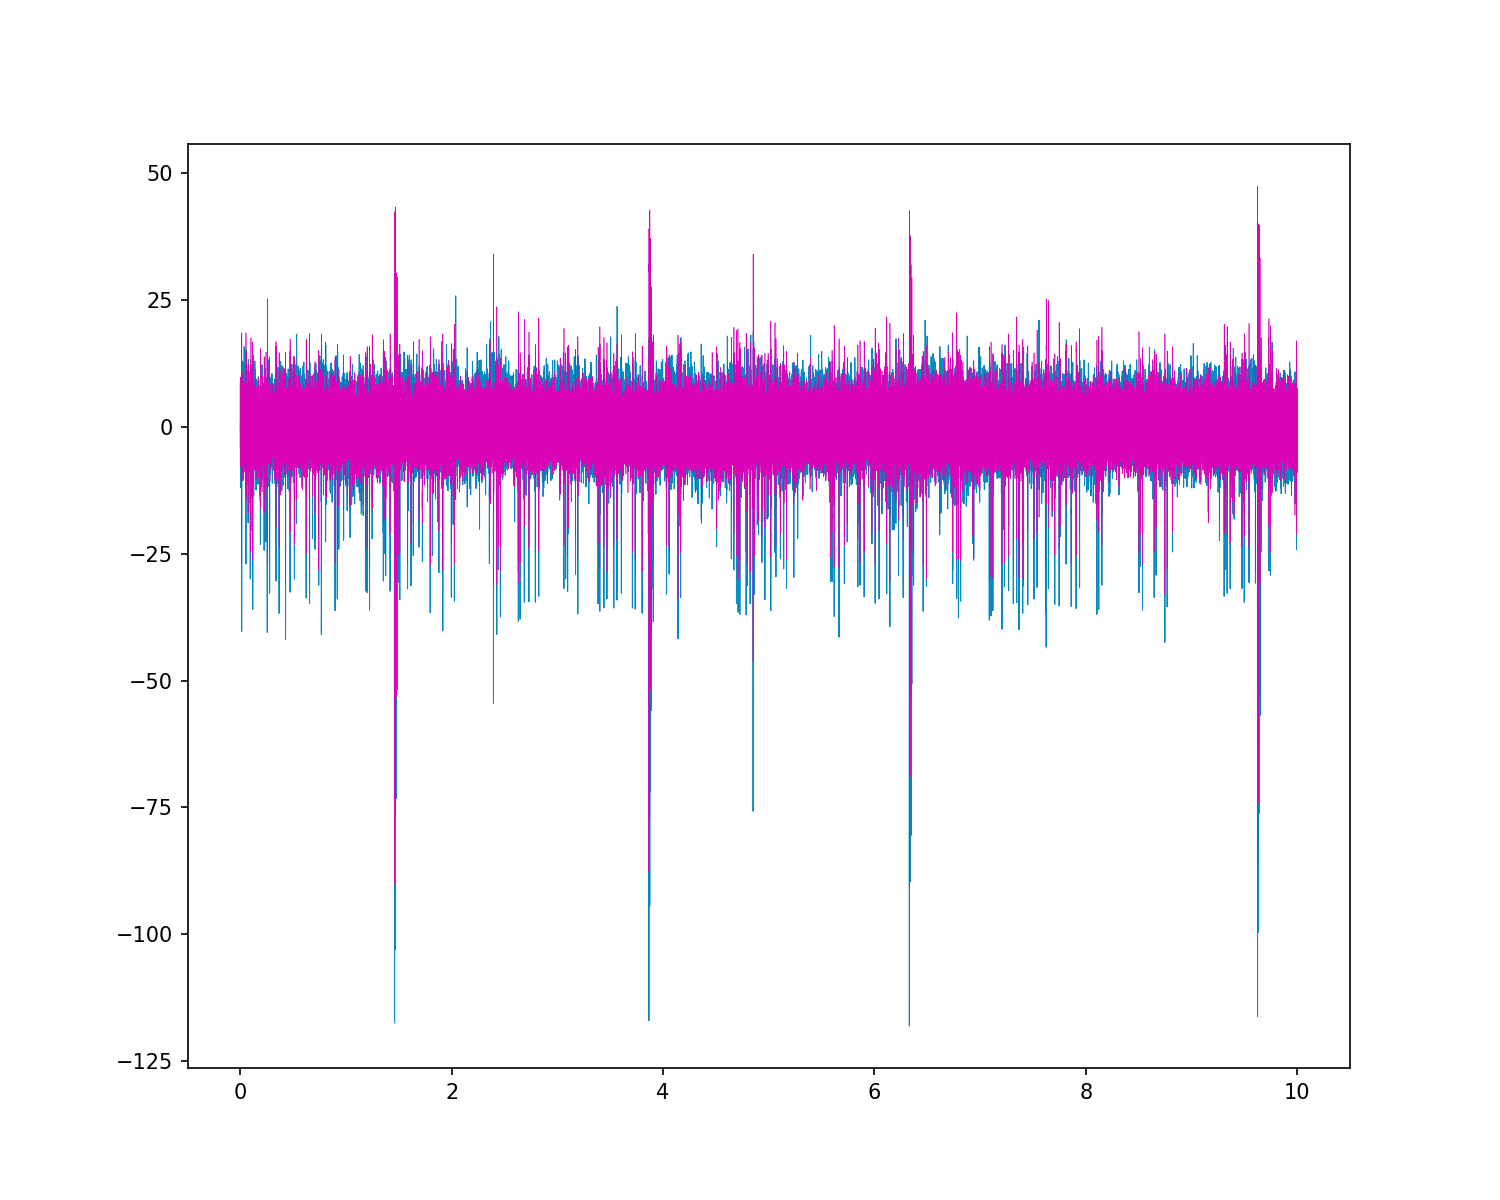

In [183]:
# plot the signal and the filter

fig, ax = plt.subplots(1, 1, figsize = (10,8))

ax.plot(time_in_sec, signal_in_uV, c = '#048ABF',  linewidth = 0.5)
ax.plot(time_in_sec, bandpassfilteredsignal, c = '#D904B5', linewidth = 0.3)


In [184]:
# Filter requirements.
T = timelengthrecording_s         # Sample Period
fs = fs      # sample rate, Hz
cutoff = 50      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 2       # sin wave can be approx represented as quadratic
n = int(T * fs) # total number of samples

In [185]:
nyq

12500.0

In [186]:
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [187]:
butter_lowpass_filtered_signal = butter_lowpass_filter(signal_in_uV, cutoff, fs, order)

<IPython.core.display.Javascript object>


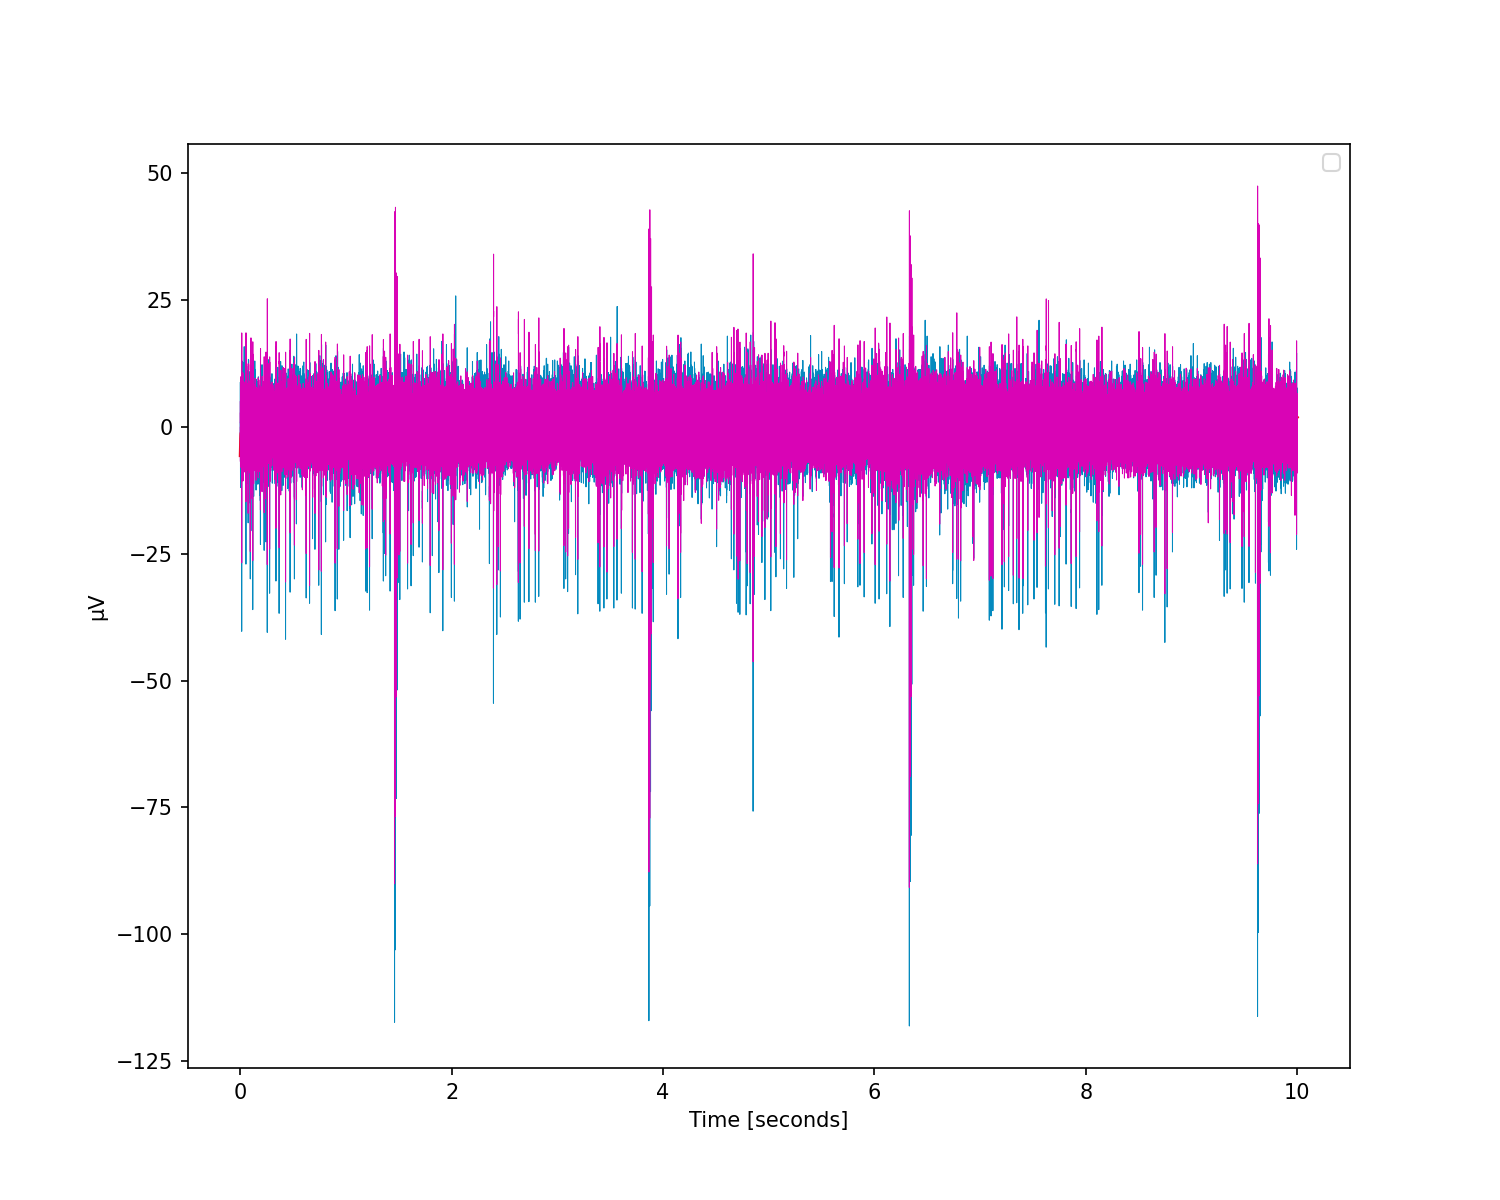

No handles with labels found to put in legend.


In [188]:
fig, ax = plt.subplots(1, 1, figsize = (10,8))

ax.plot(time_in_sec, signal_in_uV, c = '#048ABF',  linewidth = 0.5)
ax.plot(time_in_sec, butter_lowpass_filtered_signal, c = '#F20505', linewidth = 1.5)
ax.plot(time_in_sec, bandpassfilteredsignal, c = '#D904B5', linewidth = 0.5)
ax.set_xlabel('Time [seconds]')
ax.set_ylabel('µV')
ax.legend()

In [189]:
butter_lowpass_filtered_signal

array([-5.71269985, -5.66750574, -5.62238792, ...,  1.81056122,
        1.81043459,  1.81032822])

In [190]:
noise_mad = np.median(np.absolute(bandpassfilteredsignal)) / 0.6745
threshold = -5* noise_mad
artefact_threshold = -8* noise_mad
crossings = detect_threshold_crossings(
    bandpassfilteredsignal, sampling_frequency, 
    threshold, dead_time=0.003
    )
spikes=align_to_minimum(
    bandpassfilteredsignal, fs, crossings, search_range=0.003, 
    first_time_stamp=first_recording_timepoint
    )

In [191]:
spikes

array([   317,   2358,   2934,   6371,   6923,   8426,   9174,  10690,
        11771,  12796,  15573,  16371,  18545,  19168,  22411,  22938,
        29651,  30000,  30561,  33835,  34095,  34379,  35426,  36478,
        36683,  36883,  37075,  37523,  37722,  39556,  40385,  40910,
        42275,  43070,  44916,  46967,  47895,  49924,  50640,  59881,
        60667,  61049,  61524,  65770,  66176,  67182,  68262,  69787,
        70587,  76543,  76959,  77424,  77641,  79292,  79827,  84621,
        85037,  86001,  86627,  86717,  88344,  89095,  90134,  92752,
        93409,  95047,  96648,  96850,  97034,  97252,  97683, 100818,
       101428, 103529, 104152, 109045, 112662, 116747, 117372, 117752,
       118164, 119891, 120601, 121298, 121620, 122576, 123380, 124088,
       124633, 125483, 126697, 127762, 129208, 139606, 139969, 140479,
       141618, 142894, 143561, 146077, 146584, 147570, 149405, 150170,
       151099, 152907, 153657, 155766, 156806, 158263, 158456, 158652,
      

<IPython.core.display.Javascript object>


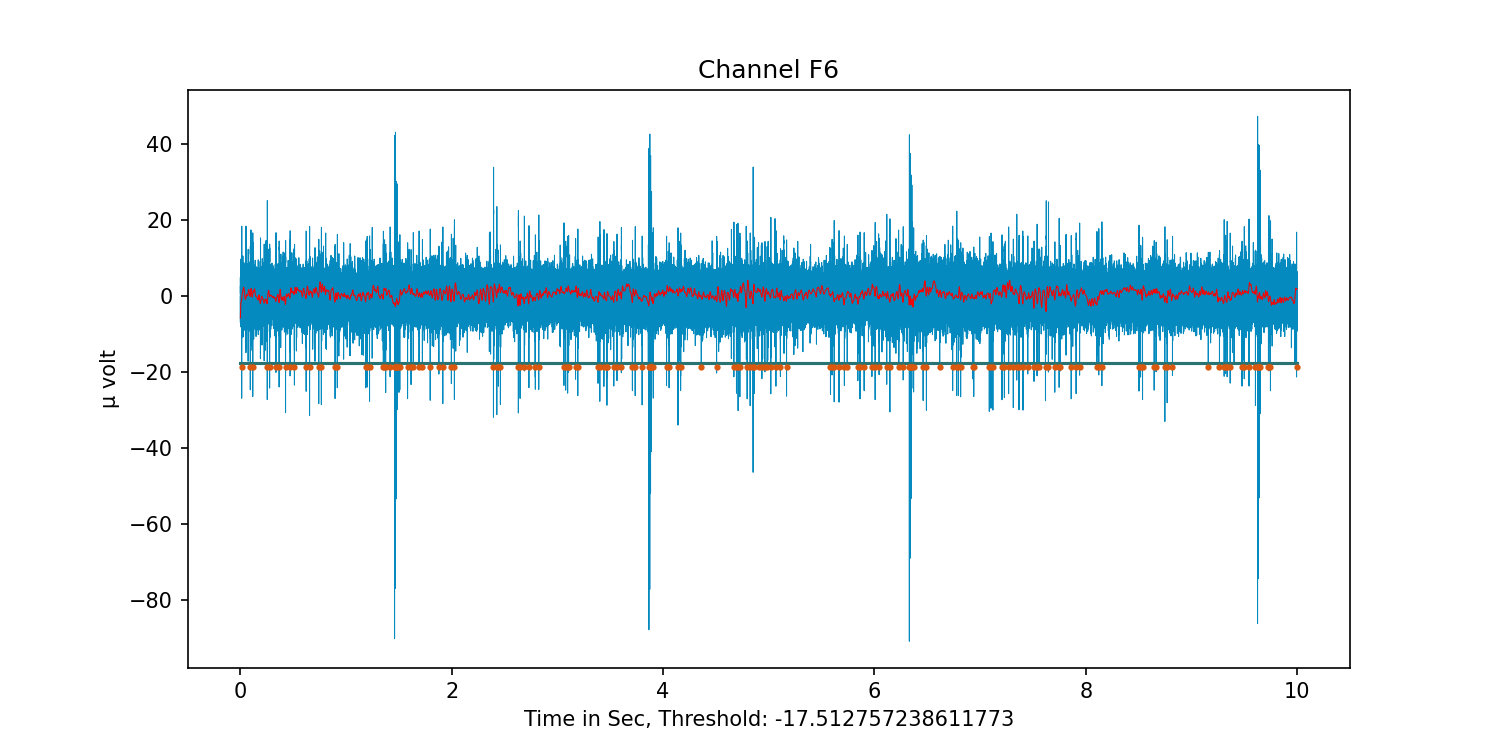

<ipython-input-192-3d89a1c96259>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax = plt.plot(spikes*tick*scale_factor_for_second, [threshold-1]*(spikes*tick*scale_factor_for_second).shape[0], 'ro', ms=2, c="#D9580D")


In [192]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = plt.plot(time_in_sec, bandpassfilteredsignal, c="#048ABF", linewidth = 0.5)
ax = plt.plot([time_in_sec[0], time_in_sec[-1]], [threshold, threshold], c="#297373")
ax = plt.plot(time_in_sec, butter_lowpass_filtered_signal, c='#F20505', linewidth=0.5)
ax = plt.plot(spikes*tick*scale_factor_for_second, [threshold-1]*(spikes*tick*scale_factor_for_second).shape[0], 'ro', ms=2, c="#D9580D")
ax = plt.title('Channel %s' %channellabel)
ax = plt.xlabel('Time in Sec, Threshold: %s' %threshold)
ax = plt.ylabel('µ volt')

fig.savefig(filebase+'_signal_'+channellabel+'_Spikes_and_LFP.png')

In [193]:
len(butter_lowpass_filtered_signal)

250001

In [194]:
# we want to find where the lfp passes a mean threshold

lfp_mean = np.mean(butter_lowpass_filtered_signal)
lfp_std = np.std(butter_lowpass_filtered_signal)

In [195]:
lfp_mean, lfp_std

(0.5320998215059836, 1.1368171941743068)

In [214]:
def lfp_crossing_detection(lowpass_filtered_signal, lfp_threshold):

    # dicts will have tuples with a start and stop of the lfp crossing
    lfp_up_crossing = []
    lfp_down_crossing = []
    
    # lfp crosses below threshold
    for i in range(0, len(lowpass_filtered_signal)-1):
        start = 0
        stop = 0
        if (lowpass_filtered_signal[i] < -lfp_threshold) and (lowpass_filtered_signal[i-1] >= -lfp_threshold):
            start = i
            while (lowpass_filtered_signal[i] < -lfp_threshold) and (i < len(lowpass_filtered_signal-1):
                stop = i
                i += 1
            lfp_down_crossing.append((start*scale_factor_for_second*tick, stop*scale_factor_for_second*tick))
            
    # lfp crosses above threshold
    
    for i in range(0, len(lowpass_filtered_signal)-1):
        start = 0
        stop = 0
        if (lowpass_filtered_signal[i] > lfp_threshold) and (lowpass_filtered_signal[i-1] <= lfp_threshold):
            start = i
            while (lowpass_filtered_signal[i] > lfp_threshold) and (i < len(lowpass_filtered_signal-1)):
                
                stop = i
                i += 1
            lfp_up_crossing.append((start*scale_factor_for_second*tick, stop*scale_factor_for_second*tick))
            
            
    return lfp_down_crossing, lfp_up_crossing
            
            
    

SyntaxError: invalid syntax (<ipython-input-214-b027a9e87299>, line 13)

In [215]:
down_cross, up_cross = lfp_crossing_detection(butter_lowpass_filtered_signal, (3*lfp_std))

In [216]:
down_cross

[(0.0, 0.00224), (7.6206, 7.625799999999999)]

In [217]:
up_cross

[(0.75172, 0.7574799999999999),
 (2.03236, 2.0358799999999997),
 (4.75672, 4.7613199999999996),
 (4.79852, 4.80564),
 (6.473559999999999, 6.481319999999999),
 (6.5542, 6.57276),
 (7.2574, 7.26128),
 (7.274039999999999, 7.283759999999999),
 (9.54696, 9.55148)]

<IPython.core.display.Javascript object>


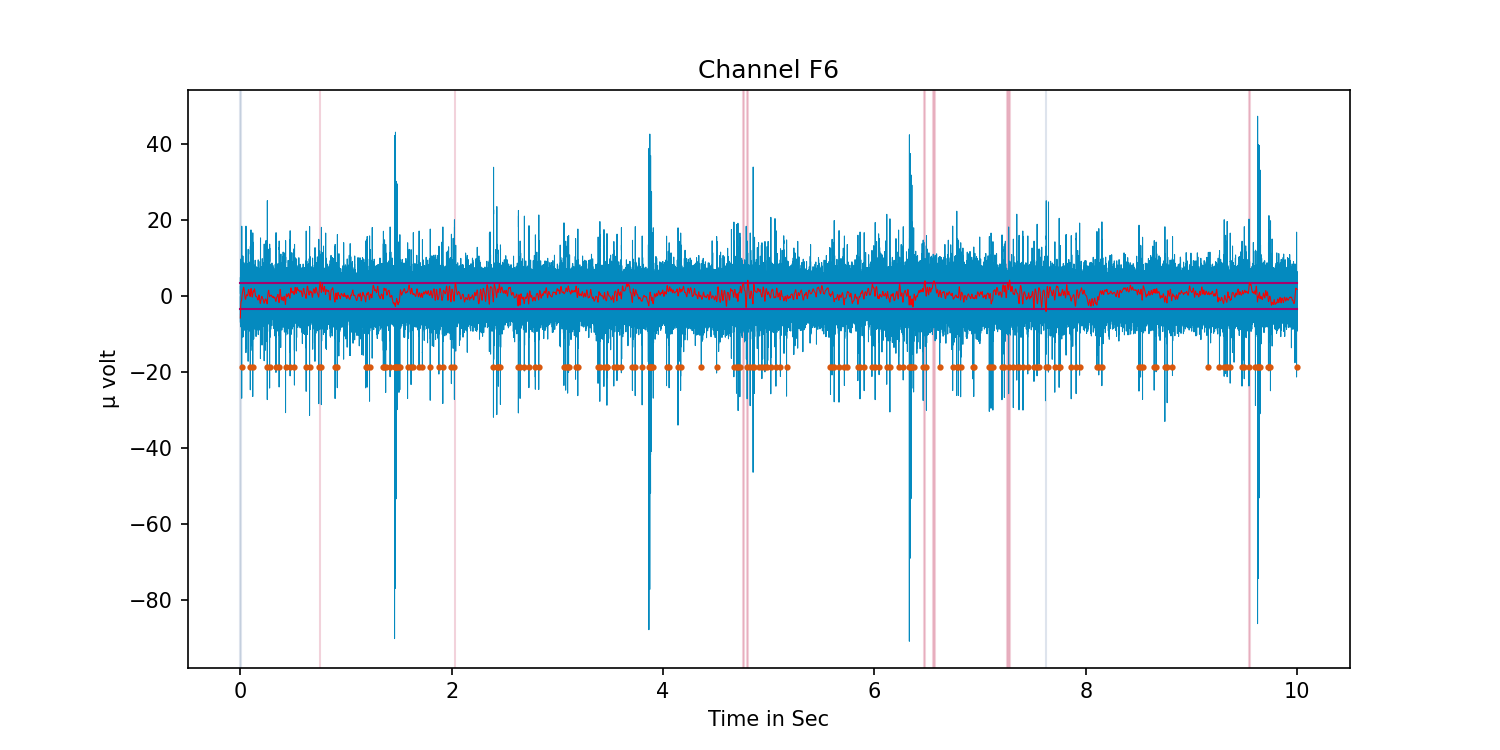

<ipython-input-206-e16e35b49c64>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax = plt.plot(spikes*tick*scale_factor_for_second, [threshold-1]*(spikes*tick*scale_factor_for_second).shape[0], 'ro', ms=2, c="#D9580D")


In [206]:
# plot the lfps

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = plt.plot(time_in_sec, bandpassfilteredsignal, c="#048ABF", linewidth = 0.5)
#ax = plt.plot([time_in_sec[0], time_in_sec[-1]], [lfp_mean, lfp_mean], c="#297373", lw=1)
ax = plt.plot(spikes*tick*scale_factor_for_second, [threshold-1]*(spikes*tick*scale_factor_for_second).shape[0], 'ro', ms=2, c="#D9580D")
ax = plt.plot([time_in_sec[0], time_in_sec[-1]], [3*lfp_std, 3*lfp_std], c="#A6036D", lw=1)
ax = plt.plot([time_in_sec[0], time_in_sec[-1]], [-3*lfp_std, -3*lfp_std], c="#A6036D", lw=1)
ax = plt.plot(time_in_sec, butter_lowpass_filtered_signal, c='#F20505', linewidth=0.5)
for i in down_cross:
    ax = plt.axvspan(i[0], i[1], color='#5D7CA6', alpha=0.2)
for i in up_cross:
    ax = plt.axvspan(i[0], i[1], color='#BF214B', alpha=0.2)

ax = plt.title('Channel %s' %channellabel)
ax = plt.xlabel('Time in Sec')
ax = plt.ylabel('µ volt')

fig.savefig(filebase+'_signal_'+channellabel+'_Spikes_and_LFP_ax_v.png')

In [219]:
os.getcwd()

'D:\\Files_Reutlingen_Jenny\\19-04-16\\190416_h5'

In [201]:
lowpass_dic

{'R12': array([-5.40731824, -5.34941796, -5.29153488, ...,  0.69765651,
         0.69771435,  0.69776041]),
 'L10': array([-3.78970613, -3.76204916, -3.73444667, ..., -0.11859162,
        -0.11858233, -0.11856961]),
 'O10': array([ 0.2844296 ,  0.29095122,  0.29752921, ..., 11.64993948,
        11.65002104, 11.65008736]),
 'P11': array([1.86308031, 1.83476298, 1.80649406, ..., 1.810746  , 1.81084812,
        1.81093579]),
 'L9': array([ 4.99649771,  4.96343688,  4.93033768, ..., -0.20928289,
        -0.2092425 , -0.2092059 ]),
 'N9': array([-3.7808846 , -3.73806696, -3.69529163, ...,  1.40756469,
         1.40757694,  1.40758326]),
 'M8': array([-5.13857288, -5.08627538, -5.03395654, ...,  1.10900821,
         1.10904496,  1.10907277]),
 'R8': array([5.78992001, 5.74104326, 5.69217996, ..., 1.22372431, 1.22373107,
        1.22373645]),
 'O6': array([ 0.29611945,  0.29869528,  0.30128464, ..., -0.79511693,
        -0.79497354, -0.7948561 ]),
 'N7': array([ 0.60871318,  0.59216074,  0.57

In [218]:
# for every channel in our lowpass_dictionary, we want the std*3 for threshold

lowpass_threshold_dic = {}
up_crossing_dic = {}
down_crossing_dic = {}

for key in lowpass_dic:
    std = np.std(lowpass_dic[key][0])
    lowpass_threshold_dic[key] = std*3
    

# we want the up crossings of the lfp
# and the donwcrossings of the lfp

for key in lowpass_dic:
    
    threshold = lowpass_threshold_dic[key]
    low_signal = lowpass_dic[key]
    
    down_cross, up_cross = lfp_crossing_detection(
        low_signal, threshold)
    
    up_crossing_dic[key] = up_cross
    down_crossing_dic[key] = down_cross

IndexError: index 250001 is out of bounds for axis 0 with size 250001

In [207]:
interesting_LFP = ['I2', 'I3', 'K2', 'K3', 'J13', 'J14', 'K13', 'K14', 'F15', 'E15']

In [208]:
fig = plt.figure(figsize=(10,10))
limit0 = 89.3
limit1 = 91.2


windowsize = 0.2 #in seconds
win = limit0
windows = []
while win < limit1:
    if win + windowsize >= limit1:
        win = limit1
        windows.append(win)
    else:
        windows.append(win)
        win += windowsize

number_interesting_LFP = len(interesting_LFP)
#fig.tight_layout()
gs1 = gridspec.GridSpec(number_interesting_LFP, 1)
gs1.update(wspace=0.025, hspace=0.05) 
axs = []

for i in range(1, len(interesting_LFP)+1):
    
    # get the key of the channel
    key = interesting_LFP[i-1]
    
    #no get all signals to plot and the lfp_down and lfp_ups
    bandpass_signal = bandpass_dic[key]
    # in the lowpass_dic there are still additional returns from the old butter filter function
    lowpass_signal = lowpass_dic[key][0]
    lfp_ups = up_crossing_dic[key]
    lfp_downs = down_crossing_dic[key]
    
    
    axs.append(fig.add_subplot(gs1[i-1]))
    
    
    axs[-1] = plt.plot(time_in_sec, bandpass_signal, c="#048ABF", linewidth = 0.5)
    axs[-1] = plt.plot(time_in_sec, lowpass_signal, c='#F20505', linewidth=1)
    
    # spikes may be added additionally
    #axs[-1] = plt.plot(spikes*tick*scale_factor_for_second, 
     #                  [100]*(spikes*tick*scale_factor_for_second).shape[0], 
      #                 'ro', ms=2, c="#D9580D")

    
    for i in lfp_downs:
        ax = plt.axvspan(i[0], i[1], color='#5D7CA6', alpha=0.2)
    for i in lfp_ups:
        ax = plt.axvspan(i[0], i[1], color='#BF214B', alpha=0.2)
    for i in windows:
        ax = plt.axvline(i)
    
    # plt xlim for zooming in the time
    plt.xlim(limit0, limit1)    
    plt.yticks(fontsize='xx-small')
    plt.ylabel(key)
    #plt.ylim(-100, 100)
    

fig.suptitle(filebase + ' lfp + banbpass from '+str(limit0)+' to '+str(limit1))
fig.savefig(
    filebase + '_lfp_and_bandpasssignal_cutout_from_' + str(limit0) +'_to_'+str(limit1)+'.png',
    bbox_inches='tight', dpi=300)

<IPython.core.display.Javascript object>

KeyError: 'I2'

In [210]:
up_crossing_dic

{}

In [104]:
lowpass_signal

(array([5.68900865, 5.66306546, 5.63711961, ..., 1.78719673, 1.78716393,
        1.78713201]),
 array([3.91302054e-05, 7.82604108e-05, 3.91302054e-05]),
 array([ 1.        , -1.98222893,  0.98238545]))

In [87]:
bandpass_dic

{'G13': array([0.15240587, 0.98626915, 2.85086618, ..., 4.41586878, 6.29010552,
        8.28649551]),
 'G12': array([ 0.64948349,  3.45910291,  7.87847738, ..., -1.65921053,
        -2.68900204, -1.96463   ]),
 'F16': array([0.20867881, 1.11628415, 2.44812598, ..., 2.22131436, 2.74884864,
        4.74255338]),
 'F15': array([ 0.81126818,  4.26813203,  9.56608197, ..., -6.68994557,
        -4.40205936, -1.73453422]),
 'F14': array([ 0.29777763,  1.54977308,  3.31574514, ..., -1.0963439 ,
        -1.03260022, -1.08972174]),
 'F13': array([0.1617847 , 0.98722675, 2.6202342 , ..., 1.36133291, 0.58687532,
        0.21216949]),
 'F12': array([ 0.88395406,  4.62491457, 10.20126516, ..., -2.62601538,
        -2.77000523, -3.05608211]),
 'E16': array([ 0.75968466,  3.86895467,  8.11199533, ..., -1.66490566,
        -3.49241667, -4.3414667 ]),
 'E15': array([ 0.1219247 ,  0.8377852 ,  2.53280444, ..., -0.23542396,
         1.13167213,  1.79729714]),
 'E14': array([ 0.08909882,  0.64216774,  2.26

In [ ]:
fig = plt.figure(figsize=(20,8))

fig.tight_layout()
fig.suptitle('Burst Propagation from ' + 
             str(np.round(b_of_interest_start, 4))+ ' to ' + 
             str(np.round(b_of_interest_end, 4)))
gs1 = gridspec.GridSpec(2, 5)

#countries = ["Country " + str(i) for i in range(1, 26)]
axs = []
time_intra_burst = 0

for i in range(1, len(time_windows)+1):
    

    plotframe = copy.deepcopy(df)
    
    # get the key for the fr_dic from the time windows:
    key = time_windows[i-1][0] # substract one because we start the for range at 1
    
    #extract the corresponding fr_dic
    fr_dic = subdivided_boi_fr[key]
    
    # fill the dataframe
    plotframe_filled = get_dict_values(plotframe, fr_dic)
    
    axs.append(fig.add_subplot(gs1[i-1]))
    # plot the heatmap
    #sns.heatmap(plotframe_filled, annot=False, linewidths=.5, ax=axstring, cmap="YlOrRd")


    axs[-1] = sns.heatmap(plotframe_filled, 
                          annot=False, vmin=0, vmax = 20, cmap='flare', 
                          cbar = False, linewidths=0.1)
    
    
    plt.setp(axs[-1], 
             title=str(int(time_intra_burst)) + ' ms')
    
    time_intra_burst += (heatmap_window*1000)

fig.savefig('divided_burst_spatial_10082021_b25.png', dpi=300, bbox_inches = 'tight')

In [42]:
np.linspace(0, 2 * np.pi, num=100)

array([0.        , 0.06346652, 0.12693304, 0.19039955, 0.25386607,
       0.31733259, 0.38079911, 0.44426563, 0.50773215, 0.57119866,
       0.63466518, 0.6981317 , 0.76159822, 0.82506474, 0.88853126,
       0.95199777, 1.01546429, 1.07893081, 1.14239733, 1.20586385,
       1.26933037, 1.33279688, 1.3962634 , 1.45972992, 1.52319644,
       1.58666296, 1.65012947, 1.71359599, 1.77706251, 1.84052903,
       1.90399555, 1.96746207, 2.03092858, 2.0943951 , 2.15786162,
       2.22132814, 2.28479466, 2.34826118, 2.41172769, 2.47519421,
       2.53866073, 2.60212725, 2.66559377, 2.72906028, 2.7925268 ,
       2.85599332, 2.91945984, 2.98292636, 3.04639288, 3.10985939,
       3.17332591, 3.23679243, 3.30025895, 3.36372547, 3.42719199,
       3.4906585 , 3.55412502, 3.61759154, 3.68105806, 3.74452458,
       3.8079911 , 3.87145761, 3.93492413, 3.99839065, 4.06185717,
       4.12532369, 4.1887902 , 4.25225672, 4.31572324, 4.37918976,
       4.44265628, 4.5061228 , 4.56958931, 4.63305583, 4.69652

In [43]:
np.cos(np.linspace(0, 2 * np.pi, num = 100))

array([ 1.        ,  0.99798668,  0.99195481,  0.9819287 ,  0.9679487 ,
        0.95007112,  0.92836793,  0.90292654,  0.87384938,  0.84125353,
        0.80527026,  0.76604444,  0.72373404,  0.67850941,  0.63055267,
        0.58005691,  0.52722547,  0.47227107,  0.41541501,  0.35688622,
        0.29692038,  0.23575894,  0.17364818,  0.1108382 ,  0.04758192,
       -0.01586596, -0.07924996, -0.14231484, -0.20480667, -0.26647381,
       -0.32706796, -0.38634513, -0.44406661, -0.5       , -0.55392006,
       -0.60560969, -0.65486073, -0.70147489, -0.74526445, -0.78605309,
       -0.82367658, -0.85798341, -0.88883545, -0.91610846, -0.93969262,
       -0.95949297, -0.97542979, -0.98743889, -0.99547192, -0.99949654,
       -0.99949654, -0.99547192, -0.98743889, -0.97542979, -0.95949297,
       -0.93969262, -0.91610846, -0.88883545, -0.85798341, -0.82367658,
       -0.78605309, -0.74526445, -0.70147489, -0.65486073, -0.60560969,
       -0.55392006, -0.5       , -0.44406661, -0.38634513, -0.32

In [47]:
sig_neo = AnalogSignal(bandpassfilteredsignal, sampling_rate=25000*pq.Hz, units='mV')

In [48]:
sig_neo

AnalogSignal with 1 channels of length 3010000; units mV; datatype float64 
sampling rate: 25000.0 Hz
time: 0.0 s to 120.4 s

In [52]:
freq, psd = welch_psd(sig_neo)

In [53]:
freq, psd

(array([0.00000000e+00, 3.73754650e-02, 7.47509299e-02, ...,
        1.24999252e+04, 1.24999626e+04, 1.25000000e+04]) * Hz,
 array([[3.37487892e-08, 1.68743888e-08, 5.46382557e-22, ...,
         3.81985992e-32, 3.97097524e-32, 1.95987874e-32]]) * mV**2/Hz)

In [54]:
freq.shape

(334445,)

In [55]:
psd.shape

(1, 334445)

<IPython.core.display.Javascript object>


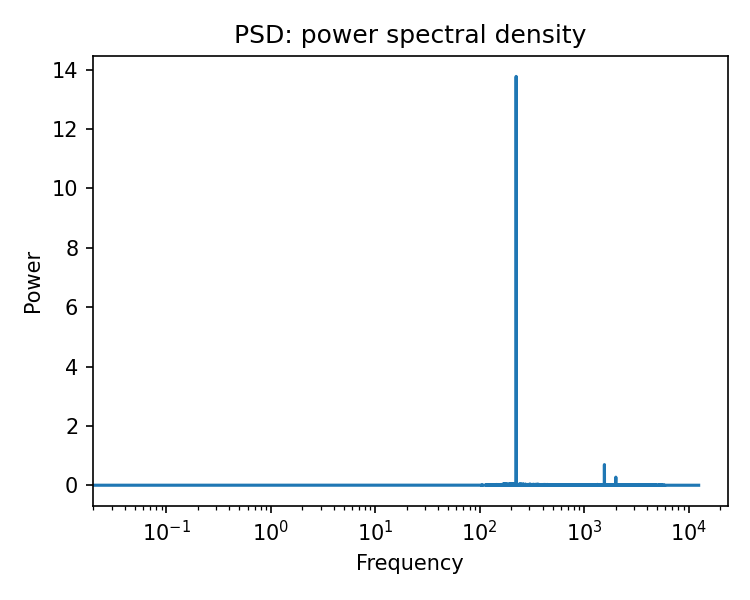

In [61]:


plt.figure(figsize=(5, 4))
plt.semilogx(freq, psd[0])
plt.title('PSD: power spectral density')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.tight_layout()